In [2]:
# Import libraries
%matplotlib widget
import isx 
import os 
import numpy as np
from scipy.fft import fft, ifft 
from scipy.ndimage import gaussian_filter 
import matplotlib.pyplot as plt
import tifffile
from tqdm import tqdm
import time
# libraries needed for the segmentation Freehand
from mpl_interactions import image_segmenter
import urllib
import PIL
from IPython.display import Image
import pandas as pd

In [3]:
notebook_path = os.getcwd()
print(notebook_path)

\\ocean.igf.internal\invivo\INSCOPIX\Ana


In [6]:
# %cd December/AnaAquiles2024/PlaqueSouris5min/Processed

\\ocean.igf.internal\invivo\INSCOPIX\Ana\December\AnaAquiles2024\PlaqueSouris5min\Processed


C:\Users\uid-1908\AppData\Local\miniconda3\envs\isxenv\lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


Data shape: (10810, 400, 352)


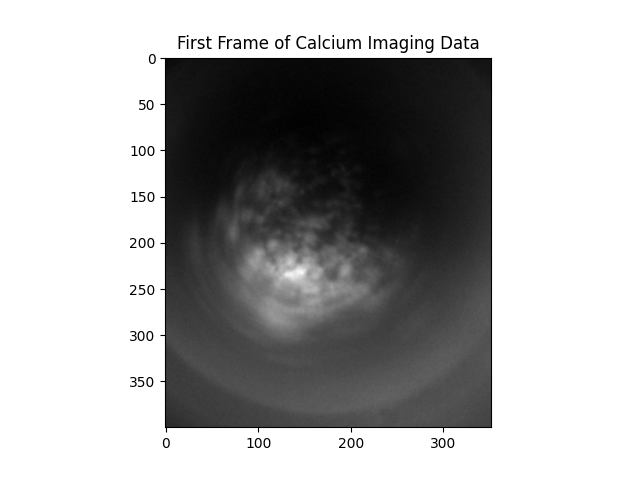

In [4]:

# Load the tiff stack
file_path = "December/AnaAquiles2024/PlaqueSouris5min/Processed/December/TiffFiles/December/Ana_training-Oct2024_2024-11-05-C29816_videoA--P.tif"
data = tifffile.imread(file_path)  # Shape: (T, X, Y) or (T, Z, X, Y) for volumetric

# Inspect the data
print(f"Data shape: {data.shape}")
plt.imshow(data[0], cmap='gray')  # Show the first frame
plt.title("First Frame of Calcium Imaging Data")
plt.show()

# Apply a Sigmoidal filter (before) of image segmentation to increase the quality of the cells 

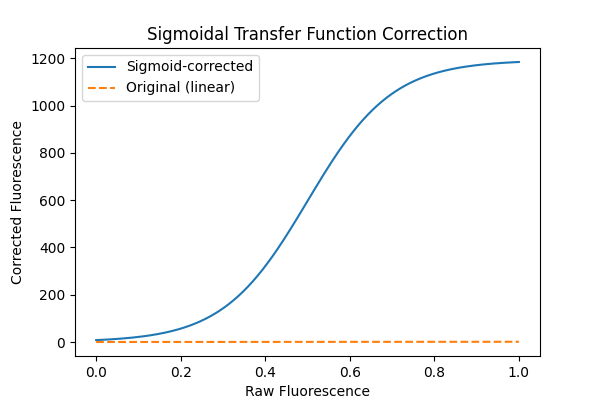

In [5]:
# Example: simulated fluorescence intensity data
raw_fluorescence = np.linspace(0, 1, 1000)  # normalized fluorescence, e.g., F/F0

# Sigmoidal correction parameters
L = 1192     # maximum value after correction
k = 10.0     # slope (steepness)
x0 = 0.5     # midpoint (where curve transitions most rapidly)

# Apply the sigmoidal correction
corrected_fluorescence = L / (1 + np.exp(-k * (raw_fluorescence - x0)))

# Plot to visualize correction
plt.figure(figsize=(6,4))
plt.plot(raw_fluorescence, corrected_fluorescence, label='Sigmoid-corrected')
plt.plot(raw_fluorescence, raw_fluorescence, '--', label='Original (linear)')
plt.xlabel("Raw Fluorescence")
plt.ylabel("Corrected Fluorescence")
plt.legend()
plt.title("Sigmoidal Transfer Function Correction")
plt.show()


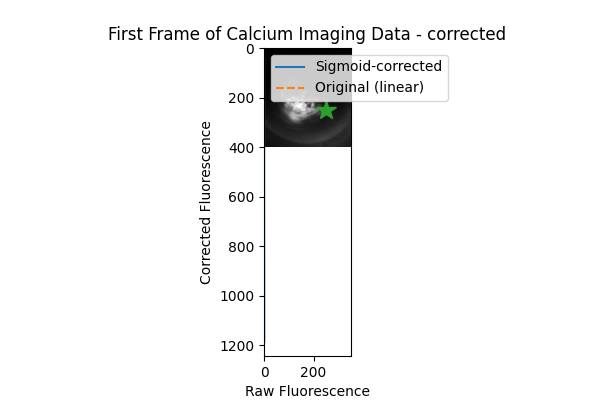

In [6]:

# Suppose you have fluorescence data from an image or time series
# e.g., loaded via tifffile, skimage, or numpy
fluorescence = data  # shape: (height, width) or (time,)

# Normalize before correction
fluorescence_norm = (fluorescence - np.min(fluorescence)) / (np.max(fluorescence) - np.min(fluorescence))

# Apply sigmoidal correction
L = 904
k = 10.0
x0 = 0.5
fluorescence_corrected = L / (1 + np.exp(-k * (fluorescence_norm - x0)))

# Optionally rescale back
fluorescence_corrected *= np.max(fluorescence)
plt.imshow(fluorescence_corrected[0], cmap='gray')  # Show the first frame
plt.plot(250,250,'*', markersize=15)
plt.title("First Frame of Calcium Imaging Data - corrected")
plt.show()

In [18]:
# tifffile.imwrite('FilmFilteredSIF.tif', fluorescence_corrected)

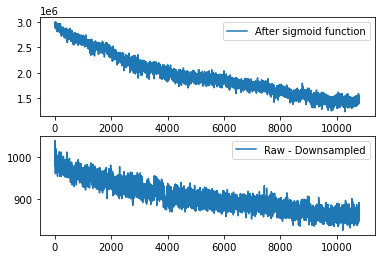

In [9]:
PixEx = fluorescence_corrected[:,250,250]
PixExRaw = data[:,50,250]

plt.figure()
plt.subplot(211)
plt.plot(PixEx, label='After sigmoid function') 
plt.legend()
plt.subplot(212)
plt.plot(PixExRaw, label = 'Raw - Downsampled') 
plt.legend()

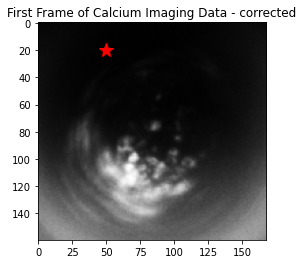

In [38]:
plt.imshow(fluorescence_corrected[0], cmap='gray')  # Show the first frame
plt.plot(50,20,'r*', markersize=15, )
plt.title("First Frame of Calcium Imaging Data - corrected")
plt.show()

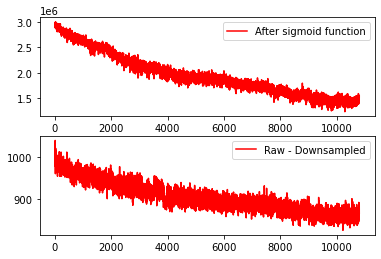

In [10]:
# Where is the BACKGROUND signal
PixEx1 = fluorescence_corrected[:,250,250]
PixExRaw1 = data[:,50,250]

plt.figure()
plt.subplot(211)
plt.plot(PixEx1,'r-', label='After sigmoid function' ) 
plt.legend()
plt.subplot(212)
plt.plot(PixExRaw1, 'r-', label = 'Raw - Downsampled')
plt.legend()

In [90]:
from scipy.optimize import curve_fit
##### recommended to first find the calibration values 

def sigmoid(x, L, k, x0):
    return L / (1 + np.exp(-k * (x - x0)))

# Suppose you have calibration data
x_measured = PixExRaw1  # measured fluorescence
y_true = PixExRaw      # true or reference fluorescence

params, _ = curve_fit(sigmoid, x_measured, y_true, p0=[1, 10, 0.5])
L_fit, k_fit, x0_fit = params


NameError: name 'PixExRaw1' is not defined

In [12]:
# L_fit

904.4029249878191

In [13]:
# k_fit

10.0

In [14]:
x0_fit

0.5

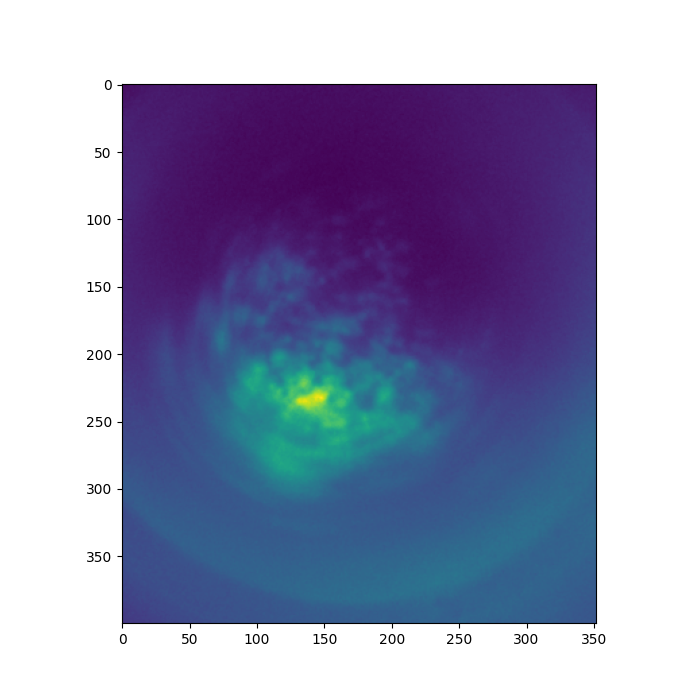

In [10]:
image = data[0]
segmenter = image_segmenter(image, mask_colors="red", mask_alpha=0.76, figsize=(7, 7))
display(segmenter)

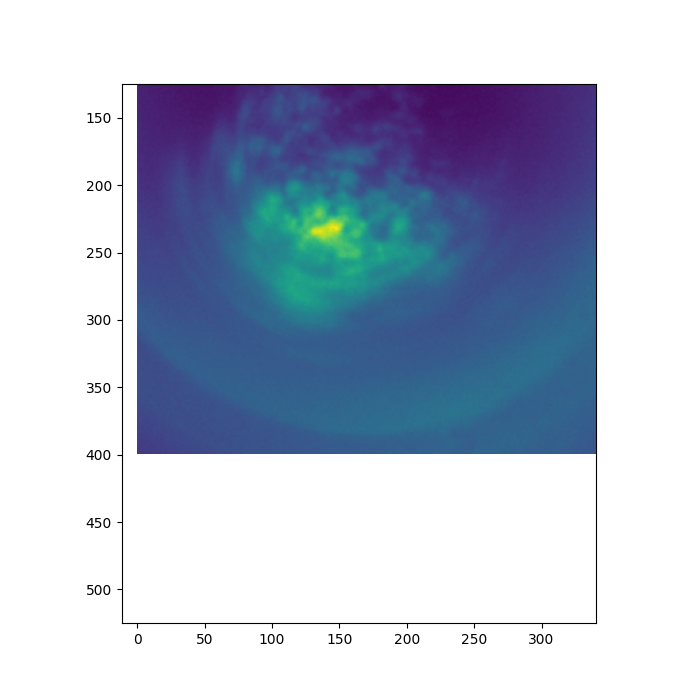

NameError: name 'multi_class_segmenter' is not defined

In [11]:
# Function to extract the values of the selected region
def extract_segmented_values():
    mask = multi_class_segmenter.mask   #segmenter.mask
    if mask is not None and mask.any():  # Check if mask is not None and has True values
        # Ensure mask is boolean
        mask = mask.astype(bool)
        segmented_values = image[mask]
        print("Shape of segmented values:", segmented_values.shape)
        print("Mean of segmented values:", np.mean(segmented_values, axis=0))
        return segmented_values
    else:
        print("No region selected or mask is not valid.")
        return np.array([])  # Return an empty array if no region is selected

# Display the segmenter
display(segmenter)

# Call the function to extract values
values = extract_segmented_values()

In [60]:
segmenter.erasing = True

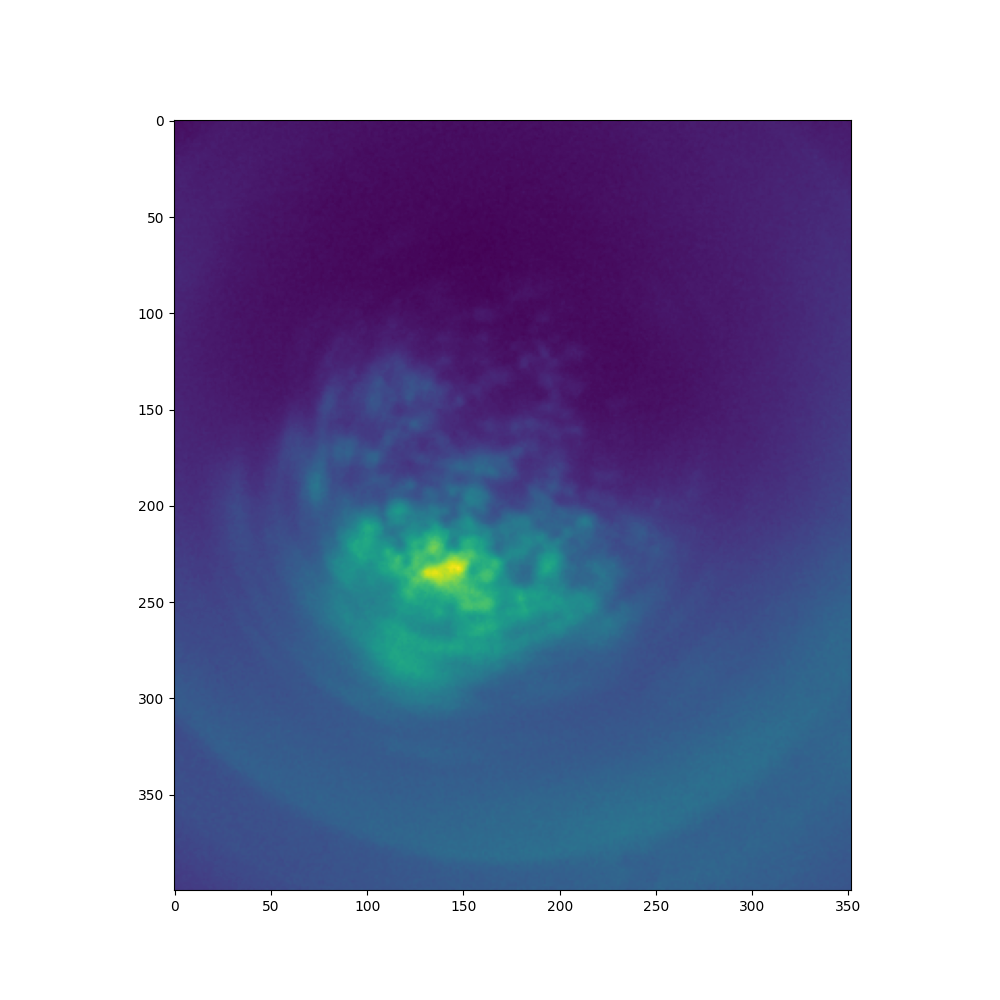

In [12]:
import ipywidgets as widgets

N_classes = 10
class_selector = widgets.Dropdown(options=list(range(1, N_classes + 1)), description="class")

def update(change):
    multi_class_segmenter.current_class = class_selector.value
    multi_class_segmenter.erasing = erasing_button.value


erasing_button = widgets.Checkbox(value=False, description="Erasing")
erasing_button.observe(update, names="value")

class_selector.observe(update, names="value")
multi_class_segmenter = image_segmenter(image, nclasses=10, mask_alpha=0.76)
display(widgets.HBox([erasing_button, class_selector]))
display(multi_class_segmenter)

In [21]:
all_segmented_data = {}

def compute_class_mean(image, mask, class_id):
    if mask is None:
        print(f"No mask available for class {class_id}.")
        return None

    class_mask = (mask == class_id)

    if not class_mask.any():
        print(f"Class {class_id}: no pixels selected.")
        return None

    # Extract pixel values
    values = image[class_mask]

    # Mean per channel (works for grayscale or RGB)
    mean_val = values.mean(axis=0)

    print(f"Class {class_id} → mean pixel value: {mean_val}")
    return mean_val

current_class = multi_class_segmenter.current_class
mean_value = compute_class_mean(image, multi_class_segmenter.mask, current_class)

all_segmented_data[f"Class {current_class}"] = mean_value

Class 10 → mean pixel value: 3205.1176470588234


# Essay to segment all the frames in the movie

Define a new variable who contains al least 100 frames

In [14]:
##### UNCOMMENT FOR THE EVALUATION OF ONLY ONE FRAME #######

# class_means = {}
# frames = 200
# FullFilm = data[frames,:,:]


# for class_id in range(1, N_classes + 1):
#     class_means[class_id] = compute_class_mean(image, multi_class_segmenter.mask, class_id)

# class_means

### For all the frames or a chunck of them 
class_means = {}
frames = 1000

FullFilm = data[:frames, :, :]   # shape (200, H, W)
mask = multi_class_segmenter.mask

for i in range(frames):
    frame_means = {}
    frame = FullFilm[i]

    for class_id in range(1, N_classes + 1):
        mean_val = compute_class_mean(frame, mask, class_id)
        frame_means[class_id] = mean_val

    class_means[i] = frame_means

Class 1 → mean pixel value: 2340.6111111111113
Class 2 → mean pixel value: 1871.5625
Class 3 → mean pixel value: 2431.0434782608695
Class 4 → mean pixel value: 1916.8
Class 5 → mean pixel value: 2777.8636363636365
Class 6 → mean pixel value: 2410.6923076923076
Class 7 → mean pixel value: 2374.190476190476
Class 8 → mean pixel value: 2166.3529411764707
Class 9 → mean pixel value: 2394.0588235294117
Class 10 → mean pixel value: 3205.1176470588234
Class 1 → mean pixel value: 2330.4444444444443
Class 2 → mean pixel value: 1848.9375
Class 3 → mean pixel value: 2429.1739130434785
Class 4 → mean pixel value: 1913.65
Class 5 → mean pixel value: 2783.5454545454545
Class 6 → mean pixel value: 2385.846153846154
Class 7 → mean pixel value: 2351.190476190476
Class 8 → mean pixel value: 2153.6470588235293
Class 9 → mean pixel value: 2385.176470588235
Class 10 → mean pixel value: 3220.823529411765
Class 1 → mean pixel value: 2301.1388888888887
Class 2 → mean pixel value: 1819.125
Class 3 → mean pixel

In [15]:

df = pd.DataFrame.from_dict({
    frame: {f"Class {c}": vals[c] for c in vals}
    for frame, vals in class_means.items()
}, orient="index")

df

,Class 1,Class 2,Class 3,Class 4,Class 5,Class 6,Class 7,Class 8,Class 9,Class 10
0,2340.611111,1871.5625,2431.043478,1916.80,2777.863636,2410.692308,2374.190476,2166.352941,2394.058824,3205.117647
1,2330.444444,1848.9375,2429.173913,1913.65,2783.545455,2385.846154,2351.190476,2153.647059,2385.176471,3220.823529
2,2301.138889,1819.1250,2402.956522,1902.05,2756.272727,2349.576923,2333.952381,2120.411765,2351.705882,3175.470588
3,2312.666667,1824.0625,2403.478261,1900.80,2761.636364,2357.692308,2328.714286,2125.529412,2354.823529,3189.058824
4,2312.472222,1796.3125,2431.565217,1906.20,2755.681818,2354.576923,2315.000000,2096.705882,2341.352941,3215.058824
...,...,...,...,...,...,...,...,...,...,...
995,1982.361111,1564.8750,2083.739130,1709.40,2283.636364,2004.076923,2001.666667,1760.235294,2005.352941,2675.705882
996,2091.833333,1616.5625,2108.043478,1741.75,2407.090909,2114.807692,2095.714286,1905.705882,2130.941176,2820.411765
997,2091.583333,1642.6875,2095.217391,1743.05,2403.363636,2120.076923,2124.904762,1939.941176,2108.000000,2850.117647
998,2093.638889,1647.4375,2106.521739,1735.50,2410.500000,2127.884615,2121.047619,1952.823529,2115.529412,2857.823529


# Plot some of the cell time-series 

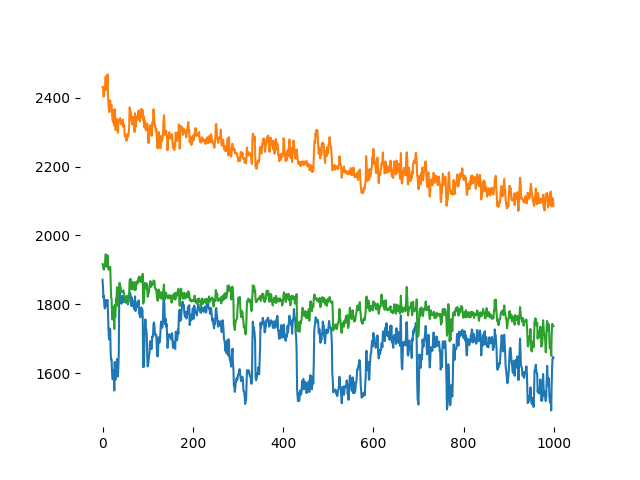

In [19]:
plt.figure()
plt.plot(df['Class 2'])
plt.plot(df['Class 3'])
plt.plot(df['Class 4'])
plt.box(False)

# Figure mask

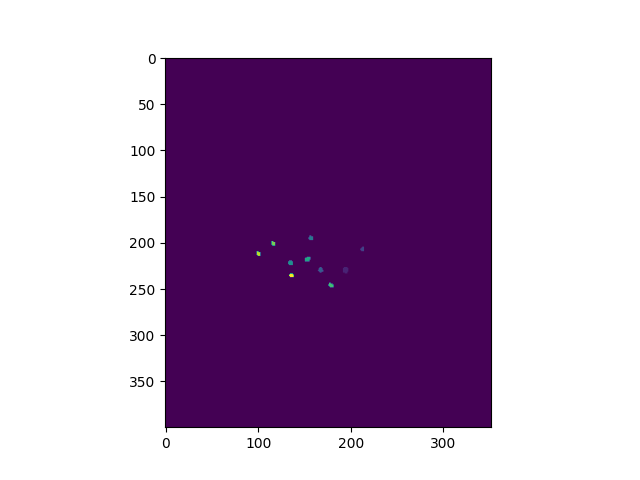

In [18]:
plt.figure()
plt.imshow(multi_class_segmenter.mask)